In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Fri Jan 12 00:34:46 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    14W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-8/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 80036
-rw-rw-r-- 1 scpark scpark   770180  1월 12 00:09 events.out.tfevents.1704985386.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37973949  1월 12 00:03 save_0
-rw-rw-r-- 1 scpark scpark   614372  1월 12 00:02 events.out.tfevents.1704985066.GPUSVR01
-rw-rw-r-- 1 scpark scpark   357092  1월 11 23:57 events.out.tfevents.1704984892.GPUSVR01
-rw-rw-r-- 1 scpark scpark   399044  1월 11 23:54 events.out.tfevents.1704984680.GPUSVR01
-rw-rw-r-- 1 scpark scpark  1103204  1월 11 22:01 events.out.tfevents.1704977556.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37979741  1월 11 22:00 save_10000
-rw-rw-r-- 1 scpark scpark   980612  1월 11 21:52 events.out.tfevents.1704977053.GPUSVR01
-rw-rw-r-- 1 scpark scpark  1754924  1월 11 21:44 events.out.tfevents.1704976148.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


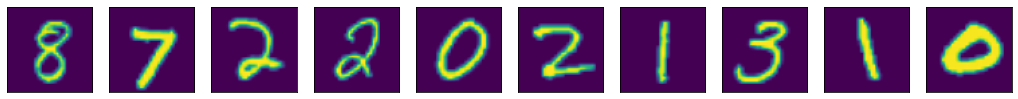

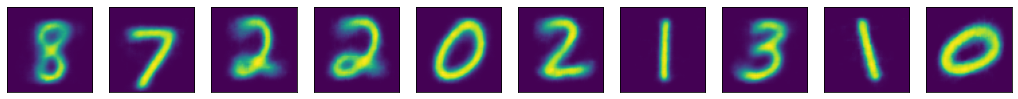

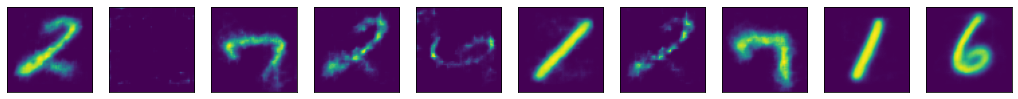

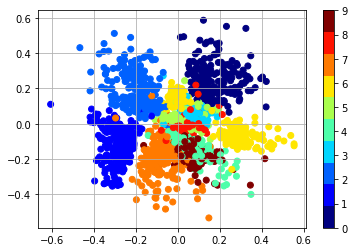

21001
lse_loss -4.788268566131592
recon_loss 0.1131867915391922
21002
lse_loss -4.787754535675049
recon_loss 0.0972394198179245
21003
lse_loss -4.787258625030518
recon_loss 0.1020130142569542
21004
lse_loss -4.788205146789551
recon_loss 0.1126893162727356
21005
lse_loss -4.788066864013672
recon_loss 0.10287334024906158
21006
lse_loss -4.787452220916748
recon_loss 0.0958876758813858
21007
lse_loss -4.787506103515625
recon_loss 0.09853553771972656
21008
lse_loss -4.787530899047852
recon_loss 0.11335553973913193
21009
lse_loss -4.787552833557129
recon_loss 0.10099085420370102
21010
lse_loss -4.78865909576416
recon_loss 0.10592242330312729
21011
lse_loss -4.78725004196167
recon_loss 0.10374008119106293
21012
lse_loss -4.787436008453369
recon_loss 0.11094729602336884
21013
lse_loss -4.788241863250732
recon_loss 0.10091854631900787
21014
lse_loss -4.787254333496094
recon_loss 0.11361148208379745
21015
lse_loss -4.788092613220215
recon_loss 0.11437256634235382
21016
lse_loss -4.78711271286010

21128
lse_loss -4.786372661590576
recon_loss 0.10777028650045395
21129
lse_loss -4.787989616394043
recon_loss 0.10424566268920898
21130
lse_loss -4.787725448608398
recon_loss 0.10638988018035889
21131
lse_loss -4.787100791931152
recon_loss 0.1011323630809784
21132
lse_loss -4.787619590759277
recon_loss 0.10313205420970917
21133
lse_loss -4.787467002868652
recon_loss 0.11238651722669601
21134
lse_loss -4.788021087646484
recon_loss 0.10928548872470856
21135
lse_loss -4.788538932800293
recon_loss 0.0983186587691307
21136
lse_loss -4.788403511047363
recon_loss 0.11033836007118225
21137
lse_loss -4.7881035804748535
recon_loss 0.10201846063137054
21138
lse_loss -4.787528038024902
recon_loss 0.10973973572254181
21139
lse_loss -4.788145542144775
recon_loss 0.1030644029378891
21140
lse_loss -4.787768840789795
recon_loss 0.10232539474964142
21141
lse_loss -4.788972854614258
recon_loss 0.10995330661535263
21142
lse_loss -4.787545204162598
recon_loss 0.0998171791434288
21143
lse_loss -4.7881102561

21256
lse_loss -4.789335250854492
recon_loss 0.10569434612989426
21257
lse_loss -4.788570404052734
recon_loss 0.10382398217916489
21258
lse_loss -4.78786563873291
recon_loss 0.10125461220741272
21259
lse_loss -4.787567138671875
recon_loss 0.10121830552816391
21260
lse_loss -4.787315368652344
recon_loss 0.10363354533910751
21261
lse_loss -4.787161827087402
recon_loss 0.10033071041107178
21262
lse_loss -4.78781270980835
recon_loss 0.11017416417598724
21263
lse_loss -4.788409233093262
recon_loss 0.10419495403766632
21264
lse_loss -4.788520336151123
recon_loss 0.10066910088062286
21265
lse_loss -4.78786563873291
recon_loss 0.10270601511001587
21266
lse_loss -4.7883710861206055
recon_loss 0.10236712545156479
21267
lse_loss -4.787511825561523
recon_loss 0.0990259051322937
21268
lse_loss -4.787996292114258
recon_loss 0.10677683353424072
21269
lse_loss -4.788186550140381
recon_loss 0.10441151261329651
21270
lse_loss -4.786915302276611
recon_loss 0.10043276846408844
21271
lse_loss -4.7877402305

KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=4e-0)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        